In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import math as mt
import plotly.offline as pyoff
import plotly.graph_objs as go
import plotly.figure_factory as ff
import scipy.stats as scs


from scipy.stats import norm
from statistics import *
from sklearn.linear_model import LinearRegression


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount ('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
ab_df = pd.read_csv("drive/My Drive/ABAdRecall.csv")
ab_df.head()


###Data exploration to get the count of unique values of categorical variables

The plot below shows that the control group has a higher count than the exposed group

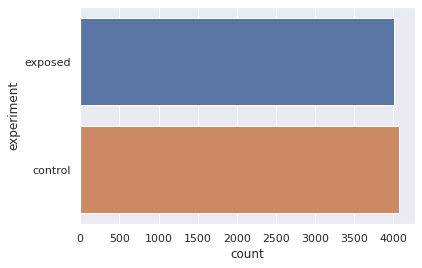

In [ ]:
sns.set(style="darkgrid")
ax = sns.countplot(y="experiment", data=ab_df)

The plot below shows that the Chrome mobile is the broswer of choice for many followed by Chrome Mobile WebView

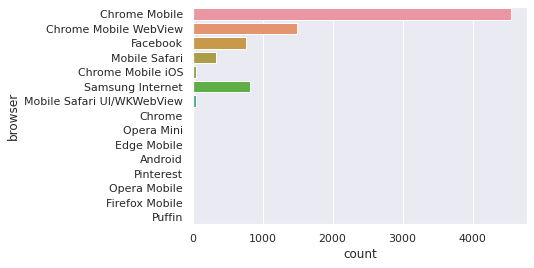

In [ ]:
sns.set(style="darkgrid")
ax = sns.countplot(y="browser", data=ab_df)

In the plot below, 1 shows the number of users that chose 'yes' for the BIO questionnaire

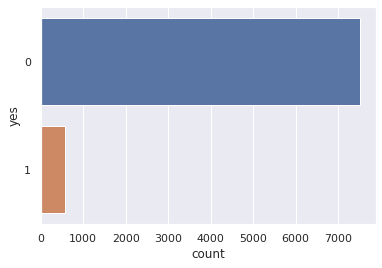

In [ ]:
sns.set(style="darkgrid")
ax = sns.countplot(y="yes", data=ab_df)

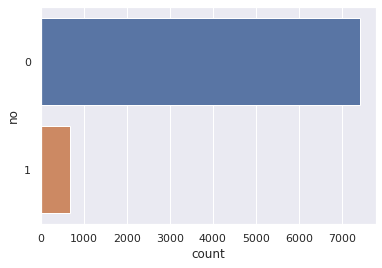

In [ ]:
sns.set(style="darkgrid")
ax = sns.countplot(y="no", data=ab_df)

The data below shows the top 10 most used decice by device make with Generic Smartphone being the most common.

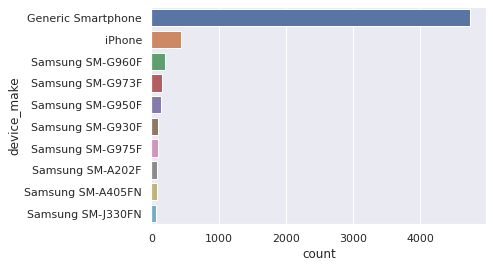

In [ ]:
device_df=ab_df.groupby('device_make')['device_make'].count().reset_index(name='count')
df1=device_df.sort_values('count',ascending=False).head(10)

sns.set(style="darkgrid")
ax = sns.barplot(x="count",y="device_make", data=df1)


###Classical A/B Test

In the next code we find out the total number of users from both categories who responded yes to the BIO questionnaire.

In [ ]:
ab_summary = ab_df.pivot_table(values='yes', index='experiment', aggfunc=np.sum)
ab_summary['total'] = ab_df.pivot_table(values='yes', index='experiment', aggfunc=lambda x: len(x))
ab_summary['rate'] = ab_df.pivot_table(values='yes', index='experiment')
ab_summary

,yes,total,rate
experiment,,,
control,264,4071,0.064849
exposed,308,4006,0.076885


Calcluation of the rate of getting a 'yes' response in both of the two groups

In [ ]:
num_control, num_exposed = 4071, 4006
yes_control, yes_exposed = 264, 308
rate_control, rate_exposed = yes_control / num_control, yes_exposed / num_exposed

Plotting the distribution of both exposed and control groups

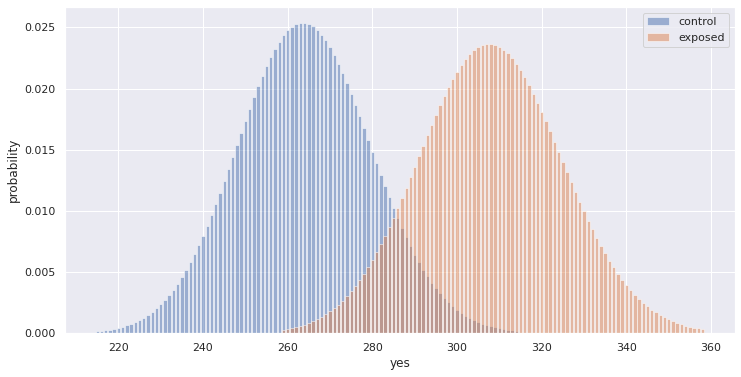

In [ ]:
from scipy.stats import binom

fig, ax = plt.subplots(figsize=(12,6))
xcon = np.linspace(yes_control-49, yes_control+50, 100)
ycon = binom(num_control, rate_control).pmf(xcon)
ax.bar(xcon, ycon, label="control",alpha=0.5)
xexp = np.linspace(yes_exposed-49, yes_exposed+50, 100)
yexp = binom(num_exposed, rate_exposed).pmf(xexp)
ax.bar(xexp, yexp, label="exposed", alpha=0.5)
plt.xlabel('yes')
plt.ylabel('probability')
leg = ax.legend();


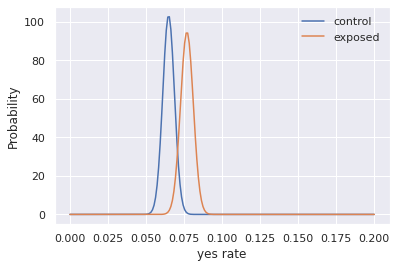

In [ ]:
##normal distribution
from scipy.stats import norm

std_control = np.sqrt(rate_control * (1 - rate_control) / num_control)
std_exposed = np.sqrt(rate_exposed * (1 - rate_exposed) / num_exposed)

yes_rate = np.linspace(0, 0.2, 200)
prob_control = norm(rate_control, std_control).pdf(yes_rate)
prob_exposed = norm(rate_exposed, std_exposed).pdf(yes_rate)

# Make the bar plots.
plt.plot(yes_rate, prob_control, label="control")
plt.plot(yes_rate, prob_exposed, label="exposed")
plt.legend(frameon=False)
plt.xlabel("yes rate"); plt.ylabel("Probability");

In [ ]:
z_score = (rate_exposed - rate_control) / np.sqrt(std_control**2 + std_exposed**2)
p = norm(rate_exposed - rate_control, np.sqrt(std_control**2 + std_exposed**2))

x = np.linspace(-0.05, 0.15, 1000)
y = p.pdf(x)
area_under_curve = p.sf(0)
plt.plot(x, y, label="PDF")
plt.fill_between(x, 0, y, where=x>0, label="Prob(exposed>control)", alpha=0.3)
plt.annotate(f"Area={area_under_curve:0.3f}", (0.02, 5))
plt.legend()
plt.xlabel("Difference in conversion rate"); plt.ylabel("Prob");

print(f"zscore is {z_score:0.3f}, with p-value {norm().sf(z_score):0.3f}")

In [ ]:
def get_confidence_ab_test(yes_control, num_control, yes_exposed, num_exposed):
    rate_control = yes_control / num_control
    rate_exposed = yes_exposed / num_exposed
    std_control = np.sqrt(rate_control * (1 - rate_control) / num_control)
    std_exposed = np.sqrt(rate_exposed * (1 - rate_exposed) / num_exposed)
    z_score = (rate_exposed - rate_control) / np.sqrt(std_control**2 + std_exposed**2)
    return norm.cdf(z_score)

print(get_confidence_ab_test(yes_control, num_control, yes_exposed, num_exposed))

0.9824645920271491


###sequential testing

In [ ]:

test_results = ab_df[ab_df.experiment == 'exposed'].yes
control_results = ab_df[ab_df.experiment == 'control'].yes

hist_data = [test_results, control_results]

group_labels = ['exposed', 'control']

# Create distplot with curve_type set to 'normal'
fig = ff.create_distplot(hist_data, group_labels, bin_size=.5,
                         curve_type='normal',show_rug=False)

fig.layout = go.Layout(
        title='High Value Customers Test vs Control',
        plot_bgcolor  = 'rgb(243,243,243)',
        paper_bgcolor  = 'rgb(243,243,243)',
    )


# Plot!
pyoff.iplot(fig)



#Machine-Learning A/B Test

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(ab_df.loc[:, ab_df.columns != 'no'],
                                                    ab_df['no'], train_size=0.9)

X_train, X_validate, y_train, y_validate = train_test_split(ab_df.loc[:, ab_df.columns != 'no'],
                                                    ab_df['no'], train_size=0.7, test_size=0.2)

###Loss function

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

def calculate_metrics(y_test, y_preds):
    rmse = np.sqrt(mean_squared_error(y_test, y_preds))
    print('RMSE Score: {}'.format(rmse))
  


Function for plotting the original values and values predicted by the model

In [ ]:
plt.style.use('ggplot')
%matplotlib inline

def plot_preds(y_test, y_preds, model_name):
    N = len(y_test)
    plt.figure(figsize=(15,5))
    original = plt.scatter(np.arange(1, N+1), y_test, c='blue')
    prediction = plt.scatter(np.arange(1, N+1), y_preds, c='red')
    plt.xticks(np.arange(1, N+1))
    plt.xlabel('no')
    plt.ylabel('yes')
    title = 'True labels vs. Predicted Labels ({})'.format(model_name)
    plt.title(title)
    plt.legend((original, prediction), ('Original', 'Prediction'))
    plt.show()

###5-fold Cross Validation

In [ ]:
from sklearn.model_selection import KFold 
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import xgboost as xgb
X_train_refined1 = X_train.drop(columns=['auction_id','experiment','date','device_make','browser'], axis=1)
Y_train_refined1 = y_train.drop(columns=['auction_id','experiment','date','device_make','browser'], axis=1)


def modelKfold(model, x,y):
  scores=[]
  cv=KFold(n_splits=5, random_state=42,shuffle=True)
  for trainIndex, testIndex in cv.split(X_train_refined1):
    cvX_train, cvX_test=x.iloc[trainIndex], x.iloc[testIndex]
    cvy_train, cvy_test=y.iloc[trainIndex], y.iloc[testIndex]

    modelTrained=model.fit(cvX_train,cvy_train)
    ypred=modelTrained.predict(x.iloc[testIndex])

    scores.append(accuracy_score(cvy_test,ypred))
  return modelTrained, scores

xGradient=xgb.XGBClassifier()
logReg=LogisticRegression()
dectree=DecisionTreeClassifier()

xGradientTrained,xgScores=modelKfold(xGradient, X_train_refined1,Y_train_refined1)
logRegTrained,lrScores=modelKfold(logReg, X_train_refined1,Y_train_refined1)
decTreeTrained,dtScores=modelKfold(dectree, X_train_refined1,Y_train_refined1)


print("xgboost scores")
print('\n'.join('{}:{}'.format(*k)for k in enumerate(xgScores)))
print("Logistic regression scores")
print('\n'.join('{}:{}'.format(*k)for k in enumerate(lrScores)))
print("Decision Tree scores")
print('\n'.join('{}:{}'.format(*k)for k in enumerate(dtScores)))




###regression

In [ ]:
X_train_refined = X_train.drop(columns=['auction_id','experiment','date','device_make','browser'], axis=1)
X_train_refined
linear_regression = sm.OLS(y_train, X_train_refined.astype(float))
linear_regression = linear_regression.fit()

In [ ]:

X_test_refined = X_test.drop(columns=['auction_id','experiment','date','device_make','browser'], axis=1)
y_preds = linear_regression.predict(X_test_refined)

In [ ]:
calculate_metrics(y_test, y_preds)


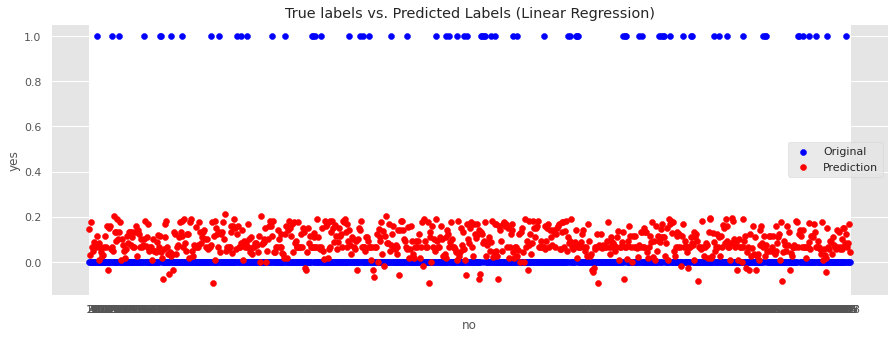

In [ ]:
plot_preds(y_test, y_preds, 'Linear Regression')


In [ ]:
print(linear_regression.summary())


In [ ]:
pd.DataFrame(linear_regression.pvalues)\
    .reset_index()\
    .rename(columns={'index':'Terms', 0:'p_value'})\
    .sort_values('p_value')

,Terms,p_value
1,platform_os,3.520422e-34
2,yes,4.941298e-10
0,hour,6.034512e-02


##Decision tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dtree = DecisionTreeClassifier(max_depth=5, min_samples_leaf =4, random_state=7)
dtree.fit(X_train_refined, y_train)
y_preds = dtree.predict(X_test_refined)

calculate_metrics(y_test, y_preds)

RMSE Score: 0.29851115706299675


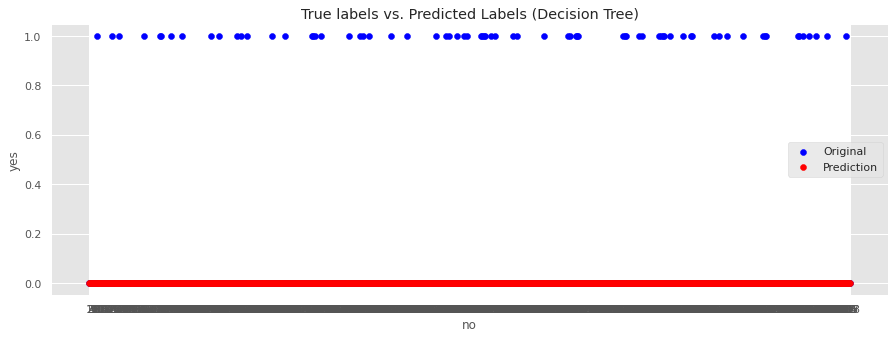

In [ ]:
plot_preds(y_test, y_preds, 'Decision Tree')


###visualization of Decision tree

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).



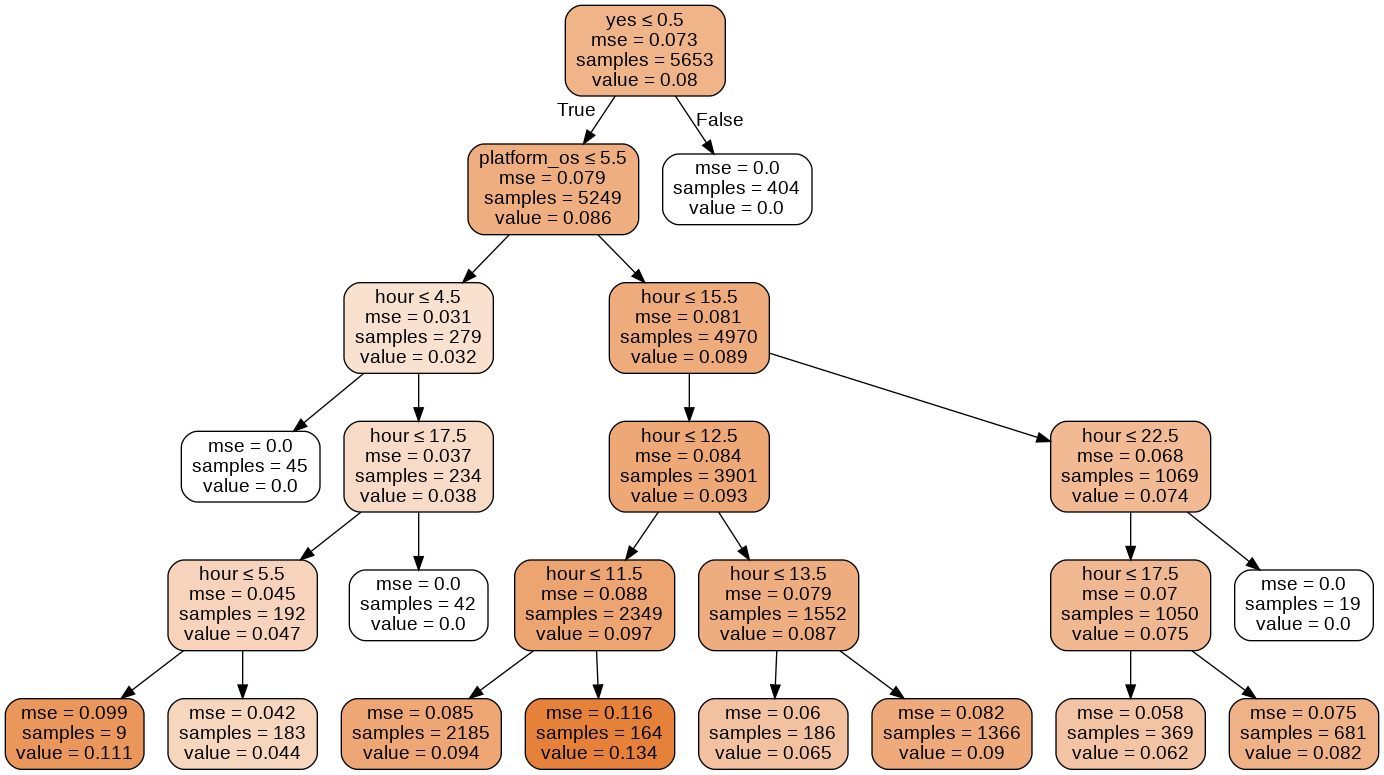

In [ ]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()

export_graphviz(dtree, out_file=dot_data, 
                feature_names=X_train_refined.columns,
                filled=True, rounded=True,
                special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

##XGBoost

In [ ]:
import xgboost as xgb

In [ ]:
DM_train = xgb.DMatrix(data=X_train_refined,label=y_train)
DM_test = xgb.DMatrix(data=X_test_refined,label=y_test)

In [ ]:
parameters = {
    'max_depth': 6,
    'objective': 'reg:linear',
    'booster': 'gblinear',
    'n_estimators': 1000,
    'learning_rate': 0.2,
    'gamma': 0.01,
    'random_state': 7,
    'subsample': 1.
}

In [ ]:
xg_reg = xgb.train(params = parameters, dtrain=DM_train, num_boost_round=8)
y_preds = xg_reg.predict(DM_test)

[08:40:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
calculate_metrics(y_test, y_preds)


RMSE Score: 0.28811683065566035


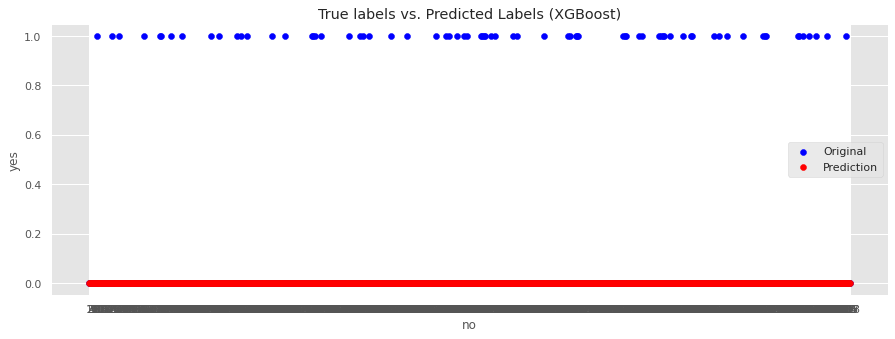

In [75]:
plot_preds(y_test, y_preds, 'XGBoost')


###Feature Importance- Decision Tree

[0.70440999 0.07691395 0.10072456 0.1179515 ]


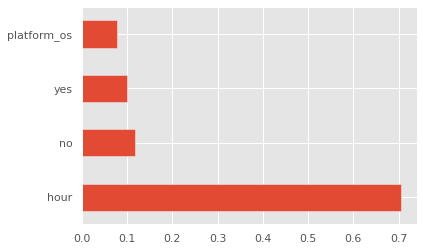

In [ ]:
ab_df1 = ab_df.drop(columns=['auction_id','experiment','date','device_make','browser'], axis=1)

X = ab_df1  #independent columns
y = ab_df1    #target column i.e price range
import matplotlib.pyplot as plt
model = DecisionTreeClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

##Sequential A/B Testing

In [ ]:
#@title
#REFERENCE
# A Conditional Sequential Test for the Equality of Two Binomial Proportions
# William Q. Meeker, Jr
# Journal of the Royal Statistical Society. Series C (Applied Statistics)
# Vol. 30, No. 2 (1981), pp. 109-115
def ConditionalSPRT(self,x,y,t1,alpha=0.05,beta=0.10,stop=None):
        if t1<=1:
            printLog('warning',"Odd ratio should exceed 1.")
        if (alpha >0.5) | (beta >0.5):
            printLog('warning',"Unrealistic values of alpha or beta were passed."
                     +" You should have good reason to use large alpha & beta values")
        if stop!=None:
            stop=math.floor(n0)

        def comb(n, k):
            return factorial(n) // factorial(k) // factorial(n - k)
        
        def lchoose(b, j):
            a=[]
            if (type(j) is list) | (isinstance(j,np.ndarray)==True):
                if len(j)<2:
                    j=j[0]
            if (type(j) is list) | (isinstance(j,np.ndarray)==True):
                for k in j:
                    n=b
                    if (0 <= k) & (k<= n):
                        a.append(math.log(comb(n,k)))
                    else:
                        a.append(0)
            else:
                n=b
                k=j
                if (0 <= k) & (k<= n):
                    a.append(math.log(comb(n,k)))
                else:
                    a.append(0)

            return np.array(a)

        def g(x,r,n,t1,t0=1):
            return -math.log(h(x,r,n,t1))+math.log(h(x,r,n,t0))

        def h(x,r,n,t=1):
            return f(r,n,t,offset=ftermlog(x,r,n,t))

        def f(r,n,t,offset=0):
            upper=max(0,r-n)
            lower=min(n,r)
            rng=list(range(upper,lower+1))
            return np.sum(fterm(rng,r,n,t,offset))

        def fterm(j,r,n,t,offset=0):
            ftlog=ftermlog(j,r,n,t,offset)
            return np.array([math.exp(ex) for ex in ftlog])

        def ftermlog(j,r,n,t,offset=0):
            xx=r-j
            lch=lchoose(n,j)
            lchdiff=lchoose(n,xx)
            lg=np.array(j)*math.log(t)
            lgsum=lch+lchdiff
            lgsum2=lgsum+lg
            lgdiff=lgsum2-offset

            return lgdiff

        def logf(r,n,t,offset=0):

            z=f(r,n,t,offset)
            if z>0:
                return math.log(z)
            else:
                return np.nan

        def clowerUpper(r,n,t1c,t0=1,alpha=0.05,beta=0.10):
            offset=ftermlog(math.ceil(r/2),r,n,t1c)
            z=logf(r,n,t1c,logf(r,n,t0,offset)+offset)
            a=-math.log(alpha/(1-beta))
            b=math.log(beta/(1-alpha))
            lower=b
            upper=1+a
            return (np.array([lower,upper])+z)/math.log(t1c/t0)
            
        l=math.log(beta/(1-alpha))
        u=-math.log(alpha/(1-beta))
        sample_size=min(len(x),len(y))
        n=np.array(range(1,sample_size+1))

        if stop!=None:
            n=np.array([z for z in n if z<=stop])
        x1=np.cumsum(x[n-1])
        r=x1+np.cumsum(y[n-1])
        stats=np.array(list(map(g,x1, r, n, [t1]*len(x1)))) #recurcively calls g

        clu=list(map(clowerUpper,r,n,[t1]*len(r),[1]*len(r),[alpha]*len(r), [beta]*len(r)))
        limits=[]
        for v in clu:
            inArray=[]
            for vin in v:
                inArray.append(math.floor(vin))
            limits.append(np.array(inArray))
        limits=np.array(limits)

        k=np.where((stats>=u) | (stats<=l))
        cvalues=stats[k]
        if cvalues.shape[0]<1:
            k= np.nan
            outcome='Unable to conclude.Needs more sample.'
        else:
            k=np.min(k)
            if stats[k]>=u:
                outcome=f'Exposed group produced a statistically significant increase.'
            else:
                outcome='Their is no statistically significant difference between two test groups'
        if (stop!=None) & (k==np.nan):
            c1=clowerUpper(r,stop,t1,alpha,beta)
            c1=math.floor(np.mean(c1)-0.5)
            if x1[n0]<=c1:
                truncate_decision='h0'
                outcome='Maximum Limit Decision. The aproximate decision point shows their is no statistically significant difference between two test groups'
            else:
                truncate_decision='h1'
                outcome=f'Maximum Limit Decision. The aproximate decision point shows exposed group produced a statistically significant increase.'
            truncated=stop
        else:
            truncate_decision='Non'
            truncated=np.nan
        return (outcome,n, k,l,u,truncated,truncate_decision,x1,r,stats,limits)

##### Use the next class structure to complete your sequential testing


In [ ]:
## your code here. include other necessary functions as you want.
class SequentialTest:
  def __init__(self,exposed,control,...):
    '''
    initialise startup variables
    '''

  
  def stoppingRule(self, ...):
    '''
    This function should take current observation and return statistical decision made. 
    Consider truncate rule for longer tests
    '''
    S, a, b,

  def computeBoundaries(self,):
    '''
    This function shoud compute boundaries 
    '''

  def plotTest(self,):
    '''
    showing the cumulative statistical test (e.g., log probability ratio) and the uper and lower limits.
    '''

  def plotBoundaries(self,):
    '''cumulative sums of exposed successes, bounded by the critical limits.
    '''


In [ ]:
def transform_data(df):
  '''
  segment data into exposed and control groups
  consider that SmartAd runs the experment hourly, group data into hours. 
      Hint: create new column to hold date+hour and use df.column.map(lambda x:  pd.Timestamp(x,tz=None).strftime('%Y-%m-%d:%H'))
  create two dataframes with bernouli series 1 for posetive(yes) and 0 for negative(no)
    Hint: Given engagement(sum of yes and no until current observation as an array) and success (yes countas an array), the method generates random binomial distribution
        #Example
           engagement = np.array([5, 3, 3])
           yes = np.array([2, 0, 3])       
         Output is "[1] 1 0 1 0 0 0 0 0 1 1 1", showing a binary array of 5+3+3 values
         of which 2 of the first 5 are ones, 0 of the next 3 are ones, and all 3 of
         the last 3 are ones where position the ones is randomly distributed within each group.
  '''
  return exposed,control

def plotDataSummary(exposed, control):
  'This function plots cummulated success'

def pretyPrintTestResult(self, test):
  '''This function print final test result. Json format is recommended. For example
  {
    "name": "",
    "engagementCountControl": ,
    "engagementCountExposed": ,
    "positiveCountControl": ,
    "positiveCountExposed": ,
    "ControlSuccessProbability": ,
    "ExposedSuccessProbability": ,
    "basePositiveRate": ,
    "significanceSign": ".",
    "lift": ,
    "oddRatio": ,
    "exactSuccessOddRate":,
    "confidenceIntervalLevel": ,
    "alpha": ,
    "beta": ,
    "power": ,
    "criticalValue": ,
    "lower critical(a)": 
    "upper critical(b)": ,
    "TotalObservation": 
  }'''

In [ ]:

######################################
'Define statistical parameters such as alpha, beta, sample size if evan approach is used, odd ratio for SPRT'
alpha=
beta=
#other variables here
'Compute statistical lower and upper decision points such as a and b'
a=
b=
#other variables here

##data processing here
exposed,control=transform_data(data)
##plot data summary
plotDataSummary(exposed,control)

'Perform test. Loop over each of data entry and perform test. Accumulate result into dataframe and print out test journey'
test=SequentialTest(...)

'Print test result.'
pretyPrintTestResult(resultObject)